# Unravelling the complex interplay between environmental drivers and conflict

This notebook contains a already relatively mature pipeline to assess the accuracy of different scale- and modelalgorithms.

**Note:** This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

In its current form, we first make a selection of conflicts to be used for training and testing the model. Selection criteria are amongst others minimum number of fatalities and climate zones. Subsequently, annual statistics (now: mean) of a range of environmental variables are determined per geographic unit (now: water provinces) and stored along with a 0/1 conflict value. The number of variables to be sampled is flexible and can be easily adapted in the cfg-file. 

This dataset is subsequently scaled, split, and applied in a machine learning model. Since there are various ways out there to scale your data and then fit and predict, the notebook is designed such that a variable amount of scalers and models can be specified. All possible combinations of scaler and model are then evaluated and output saved to an output directory.

All model settings need to be defined in the run_settings.cfg file.

For questions, please contact J.M. Hoch (j.m.hoch@uu.nl).

With contributions from N. Wanders (Utrecht University) and S. de Bruin (PBL).

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, neighbors, naive_bayes, preprocessing, model_selection, metrics
from shutil import copyfile, rmtree
import os, sys

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.2b3
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions. If the environment.yml file is used to create a separate conda-environment, this should not raise a problem.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.optionxform = lambda option: option
config.read(settings_file);

Create the output folder as specified in the settings, in case it does not exist yet. Also, all output stored there from previous runs will be removed for a clean start.

In [6]:
out_dir = os.path.abspath(config.get('general','output_dir'))
if os.path.isdir(out_dir):
    rmtree(out_dir)
os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir))

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT


Make a copy of the settings file in the output file to always get an idea on what settings the output is based upon.

In [7]:
copyfile(settings_file, os.path.join(out_dir, 'copy_of_run_setting.cfg'));

# Filter conflicts

Not all conflicts of the database should be used for the model. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is very likely that the conflict is not water-related.

First, get the conflict data base and convert it into a georeferenced dataframe. This is needed for all following steps where this data is combined with other data sources.

In [8]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



Second, get the subset of conflicts based on user-defined conditions in the settings file. To filter out non-water-related conflicts, we use only those conflicts falling in climate zones notoriously known for water shortages.

In [9]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2015

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Analysis per year

This is an essential part of the code. Here, we go through all model years as specified in the settings-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit or not;
2. Loop through various files with environmental variables and get mean variable value per geographical unit.

This is all stored in a dictionary for easy processing. We first need to initialize this dictionary containing a pandas Series per provided environmental variable. To keep this automated, each 'key' in the section 'env_var' in the cfg-file should be equal to the variable name used on the corresponding nc-file. Then, add a pandas Series for the conflict data.

In [10]:
XY = {}
for key in config.items('env_vars'):
    XY[str(key[0])] = pd.Series(dtype=float)
XY['conflict'] = pd.Series(dtype=int)
XY

{'GDP_per_capita_PPP': Series([], dtype: float64),
 'total_evaporation': Series([], dtype: float64),
 'precipitation': Series([], dtype: float64),
 'surface_water_storage': Series([], dtype: float64),
 'upper_soil_storage': Series([], dtype: float64),
 'groundwater_recharge': Series([], dtype: float64),
 'temperature': Series([], dtype: float64),
 'int_grazing': Series([], dtype: float64),
 'ext_grazing': Series([], dtype: float64),
 'conflict': Series([], dtype: int32)}

Now let's go through all years and all files and data and assign the values to the corresponding Series in the dictionary.

In [11]:
%%capture

print('simulation period from', str(config.getint('settings', 'y_start')), 'to', str(config.getint('settings', 'y_end')))
print('')

# go through all simulation years as specified in config-file
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):
    
    print('entering year {}'.format(sim_year) + os.linesep)
    
    # go through all keys in dictionary
    for key, value in XY.items():
        
        if key == 'conflict':
            data_series = value
            data_list = conflict_model.get_boolean_conflict.conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year)
            data_series = data_series.append(pd.Series(data_list), ignore_index=True)
            XY[key] = data_series
            
        else:
            nc_fo = os.path.join(config.get('general', 'input_dir'), 
                                 config.get('env_vars', key))
            
            print('calculating mean {0} per aggregation unit from file {1} for year {2}'.format(key, nc_fo, sim_year))

            nc_ds = xr.open_dataset(nc_fo)
            
            if (np.dtype(nc_ds.time) == np.float32) or (np.dtype(nc_ds.time) == np.float64):
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_float_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
            elif np.dtype(nc_ds.time) == 'datetime64[ns]':
                data_series = value
                data_list = conflict_model.get_var_from_nc.nc_with_continous_datetime_timestamp(extent_gdf, config, key, sim_year)
                data_series = data_series.append(pd.Series(data_list), ignore_index=True)
                XY[key] = data_series
                
            else:
                raise Warning('this nc-file does have a different dtype for the time variable than currently supported: {}'.format(nc_fo))
                
print('...simulation DONE')

# Machine Learning

## Data preparation

Before we can get started, we have to prepare the sampled data such that it is compatible with the Machine Learning (ML) models.

First, create a pandas dataframe from the dictionary and kick out rows with missing values as they do not work with ML models.

In [12]:
XY = pd.DataFrame.from_dict(XY)
print('number of data points including missing values:', len(XY))
XY = XY.dropna()
print('number of data points excluding missing values:', len(XY))

number of data points including missing values: 5790
number of data points excluding missing values: 5760


Then, convert them to numpy arrays, separately for the variables (X) and the target conflict (Y).

In [13]:
X = XY.to_numpy()[:, :-1] # since conflict is the last column, we know that all previous columns must be variable values
X

array([[2.36193426e+03, 4.23162297e-02, 5.90158959e-02, ...,
        1.69482798e+01, 4.27550003e-02, 4.27550003e-02],
       [3.10405169e+03, 4.05202232e-02, 4.38823540e-02, ...,
        2.62989597e+01, 4.27103449e-02, 4.27103449e-02],
       [1.19202521e+03, 3.92765536e-02, 3.85574701e-02, ...,
        2.41465799e+01, 4.27550003e-02, 4.27550003e-02],
       ...,
       [1.70019058e+03, 4.56631968e-02, 7.90373737e-02, ...,
        1.99556426e+01, 2.07449999e-02, 2.07449999e-02],
       [1.71027506e+03, 4.38179032e-02, 5.47764229e-02, ...,
        2.20619215e+01, 2.07449999e-02, 2.07449999e-02],
       [1.71202357e+03, 5.35152570e-02, 5.75030690e-02, ...,
        2.21496095e+01, 2.07449999e-02, 2.07449999e-02]])

In [14]:
Y = XY.conflict.astype(int).to_numpy()
Y

array([0, 0, 0, ..., 0, 0, 0])

### Target evaluation

Let's have a closer look at what we actualy work with. This is essential to select and tune the right ML model, for instance.

In [15]:
print('the total number of data points for our target is', len(Y))

the total number of data points for our target is 5760


In [16]:
print('from this, {0} points are equal to 1, i.e. represent conflict occurence. This is a fraction of {1} percent.'.format(len(np.where(Y != 0)[0]), round(100*len(np.where(Y != 0)[0])/len(Y), 2)))

from this, 310 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 5.38 percent.


We see that only a very small amout of conflicts are sampled. This small fraction compared to the vast amoutn of non-conflicts indicates we have an **imbalanced problem** and thus will need to account for this in the settings of the model used and data pre-processing.

## ML modelling pipeline

This pipeline allows to combine various scalers and models to find the best-performing combination and assess sensitivities.

### Data pre-processing

Before we can train and predict with the model, we need to scale the variable data. This is required because our input data has a range of units (or not) and values vary in orders of magnitude. 

Besides, it is important to create separate training- and testdata for both variables and target.

#### Scaler

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

The scaler is then used to fit the data and transform it according to scaler-specific method. I don't scale Y since it is either 0 or 1 already.

The scaled variable data X_scaled is, together with the target data Y, split into trainings and test data. The fraction of the total data that is used for training is user-defined.

The scatterplot of the first two variables in X_train looks like this. Also the sample size n_train is provided used to train the data alongside with the total variable sample size n_tot.

In [59]:
scalers = [preprocessing.MinMaxScaler(),
           preprocessing.StandardScaler(),
           preprocessing.RobustScaler(),
           preprocessing.QuantileTransformer()
          ]

### Models

The variety of ML models is sheer endless. We here use two models for supervised learning which showed better performance than other candidates in previous assessment rounds. Also, all model parameters were already calibrated using GridSearchCV in previous analyses.

In [66]:
clfs = [
    svm.NuSVC(nu=0.1, kernel='rbf', class_weight={1: 100}, random_state=42, probability=True, degree=10, gamma=10),
    neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance'),
]

### The pipeline

The model pipeline starts with **splitting the data in scaled train and test samples**. 

It then contains a number of steps which are performed for each scaler-model combination, explained hereafter.

#### ***k-fold cross-validation***

It is important to check how robust the models are in terms of accuracy as well as under- and overfitting. To that end, we apply **cross-validation (CV)** to fit the training-data against each other by splitting it up in chunks (as defined by k) and one chunk against all other k-1 chunks. k is 10 in our case, the default value is 5.

#### ***Model fitting and prediction***

Subsequently, we fit the models based on the training-data. With a fitted model, we can predict our target based on the remaining test-data.

#### ***Evaluation***

We have now produced a set of predictions, y_pred. This can be comapred with the retained test-targets y_test to evaluate the prediction. There are many ways to do this and several are applied here.

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The main classification metrics are nicely summarized in the **classification report**:

**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Another nice way to vizualize the accuracy of our results is the **confusion matrix**. The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

Yet another metric is the **Brier score** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated

Last but not least, the **F1 score**, also known as balanced F-score or F-measure. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1%20score#sklearn.metrics.f1_score)

C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.p

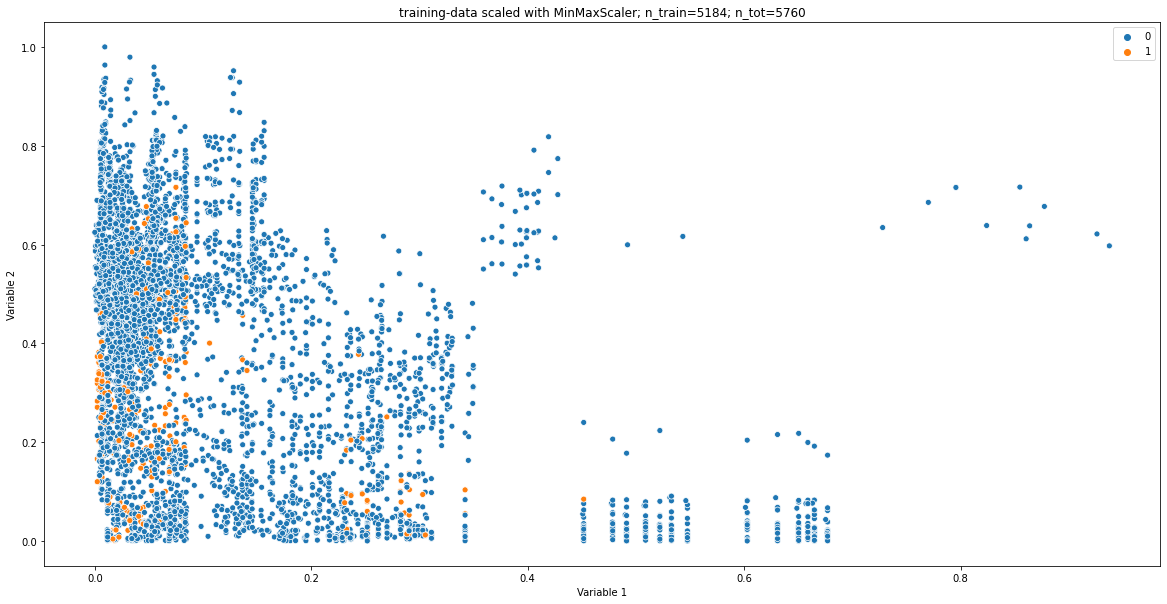

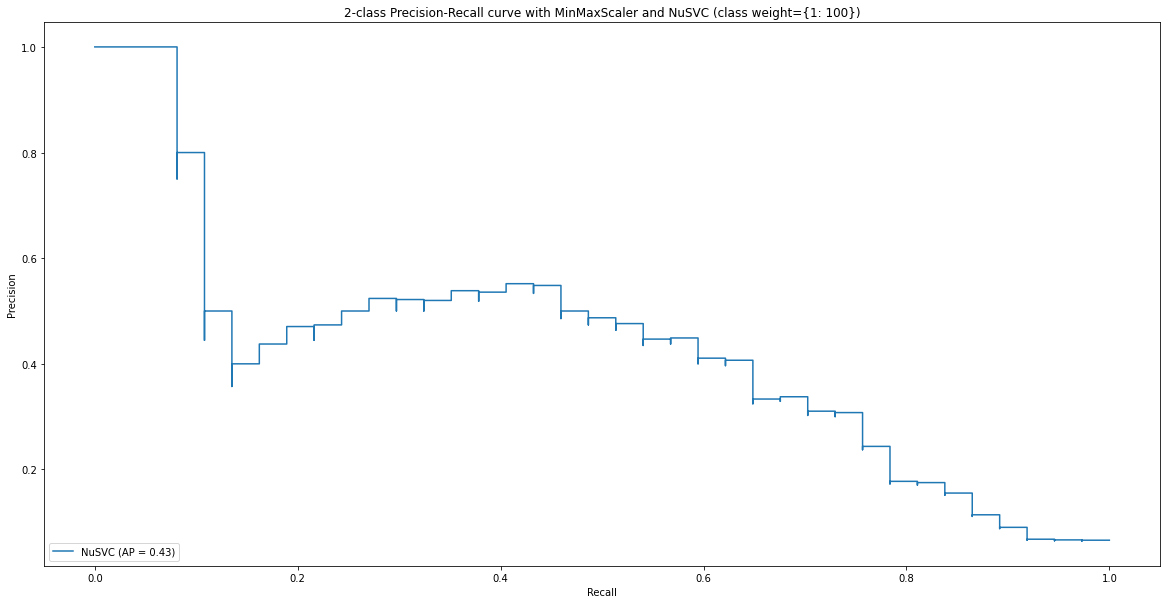

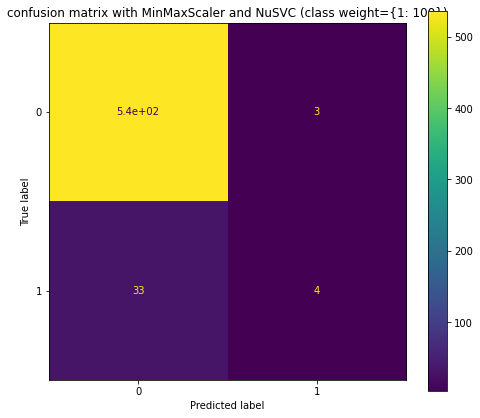

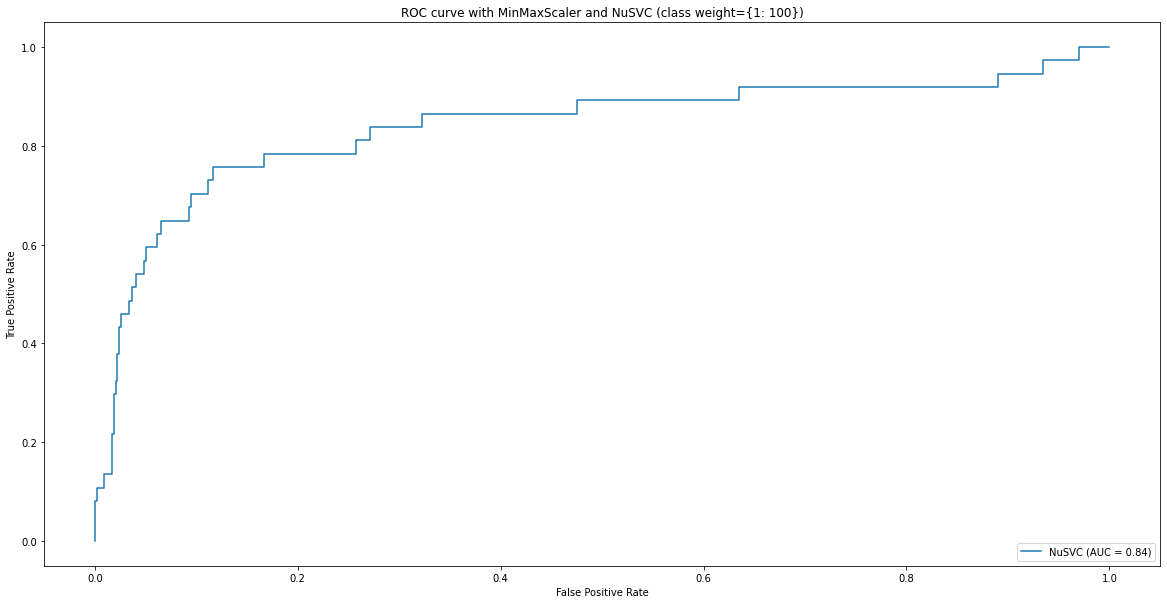

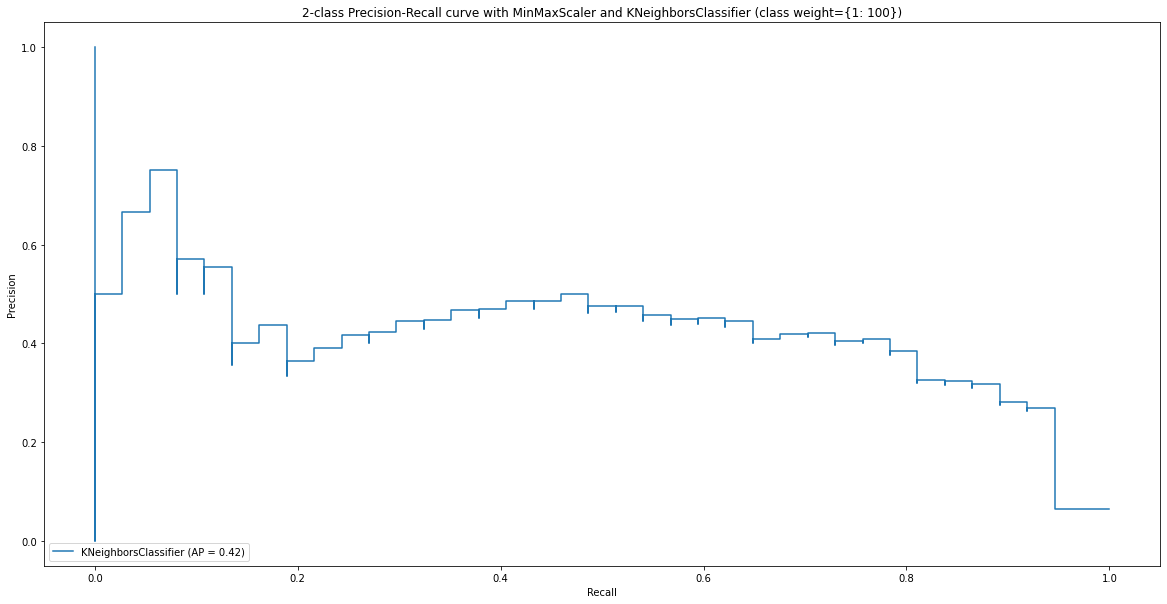

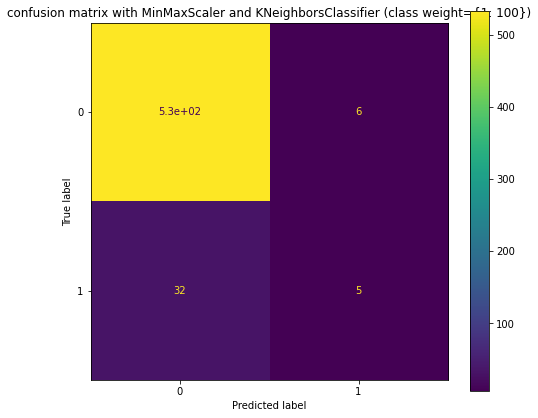

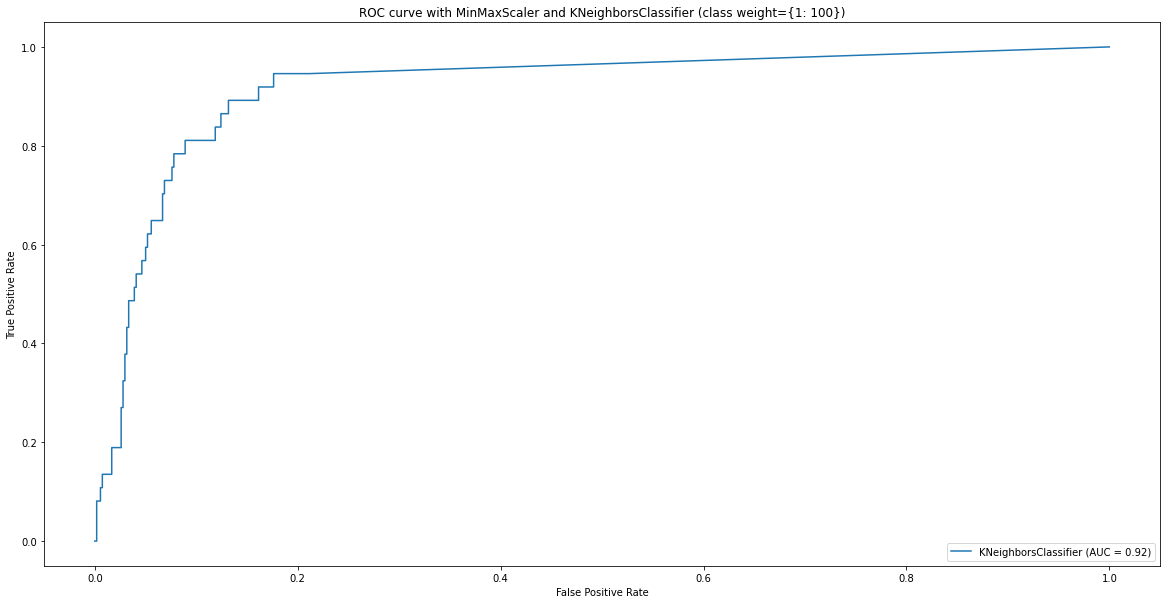

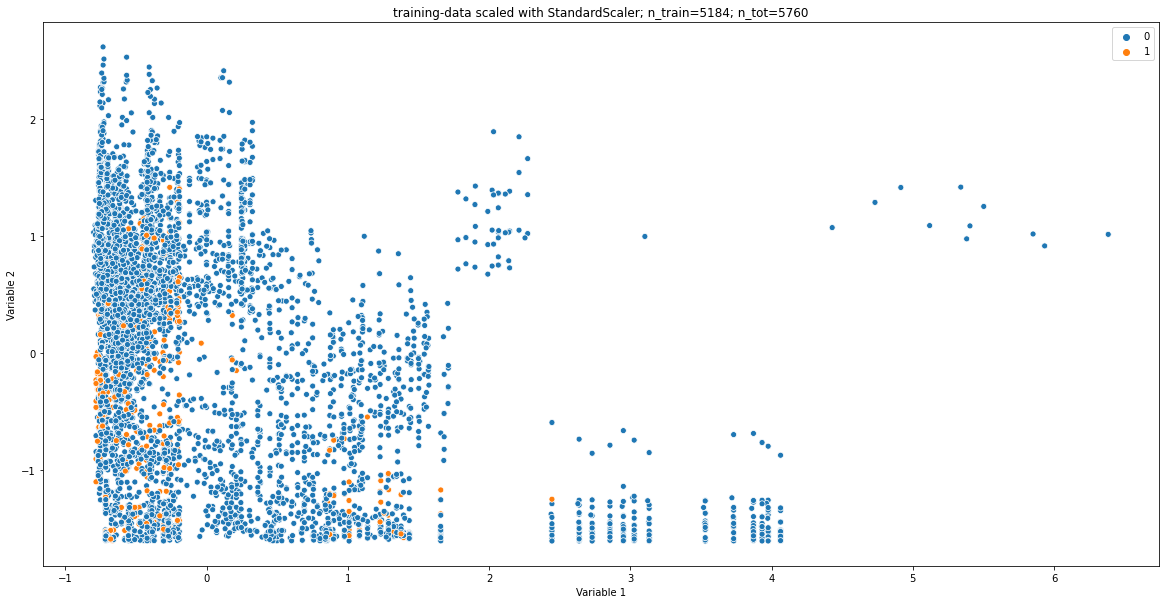

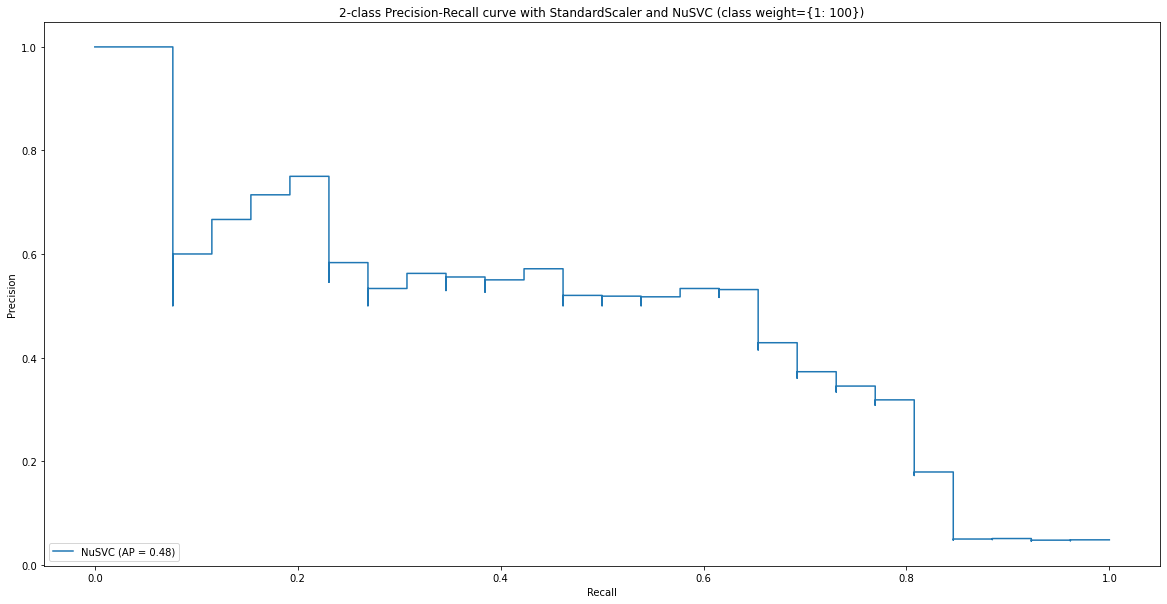

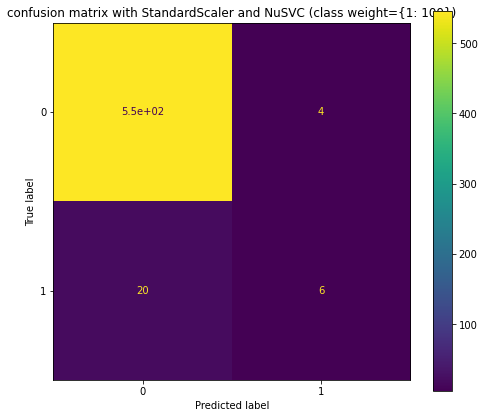

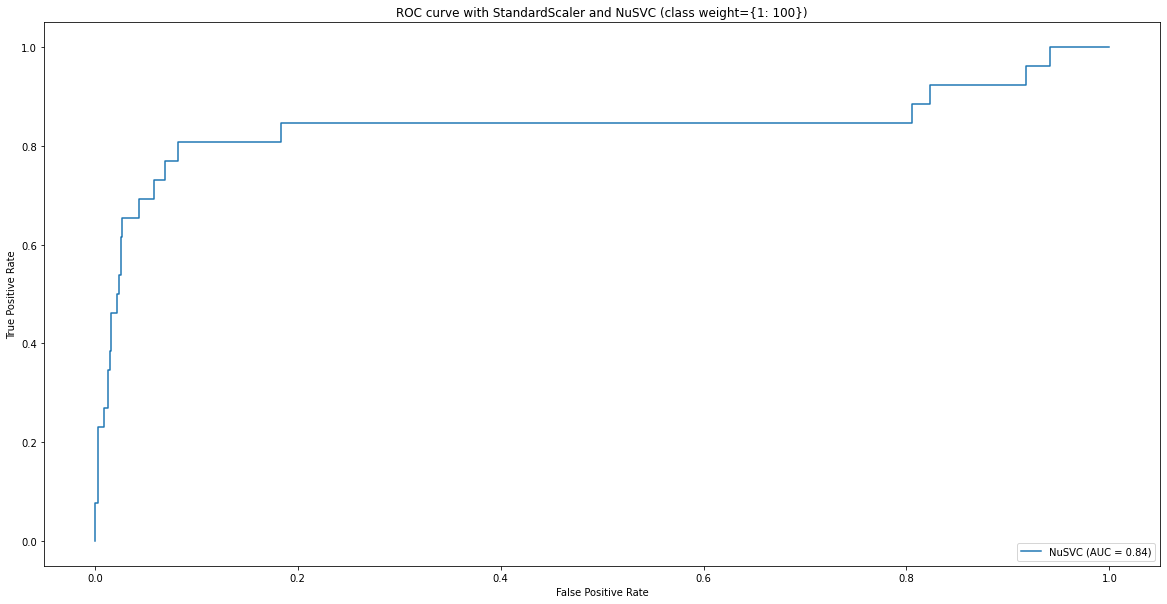

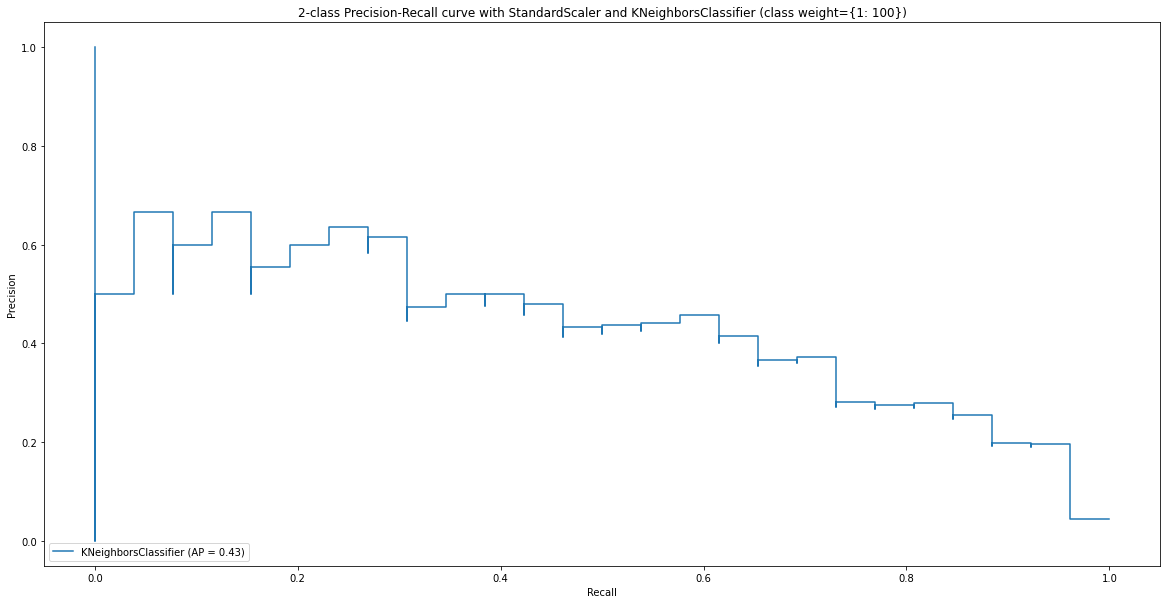

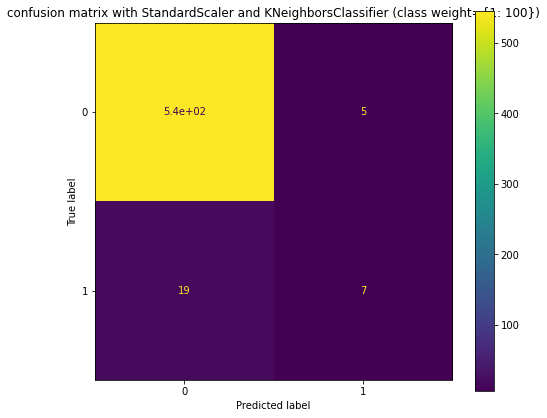

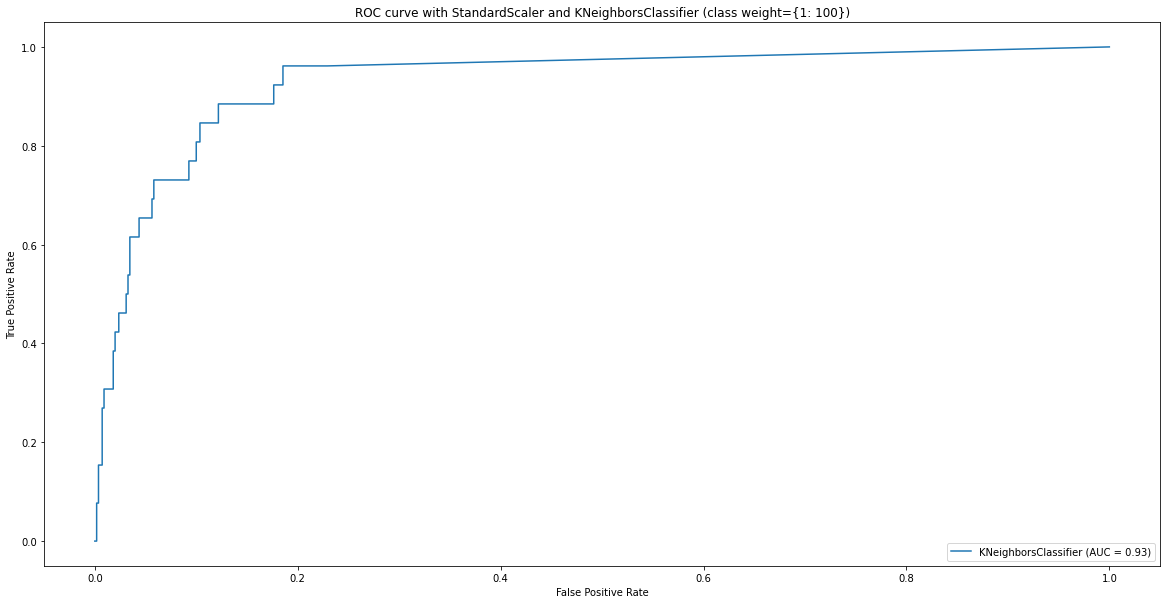

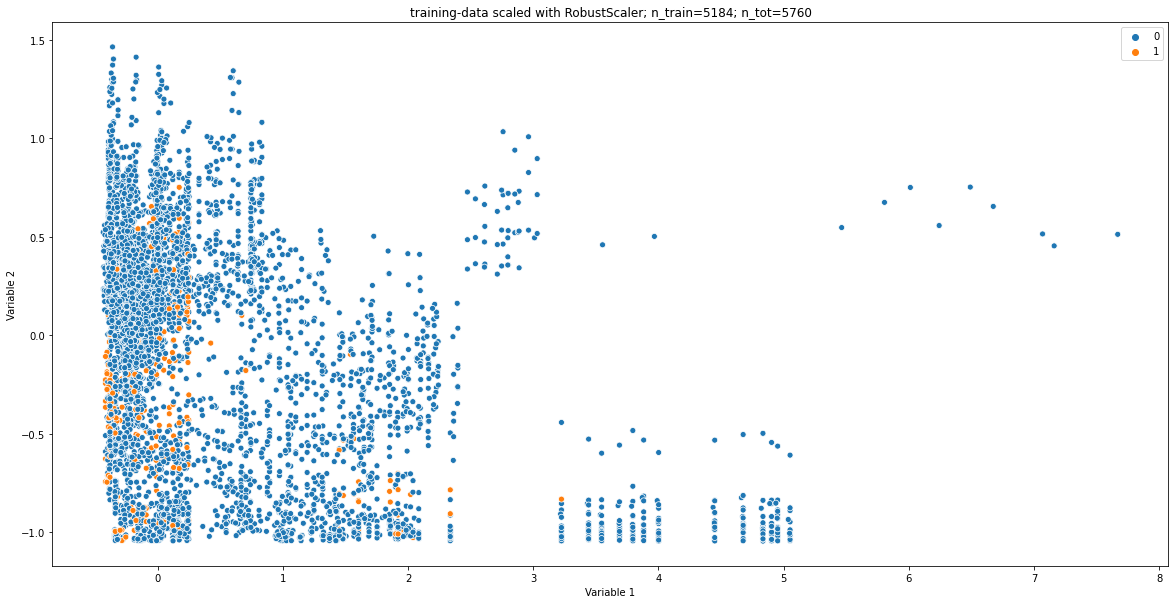

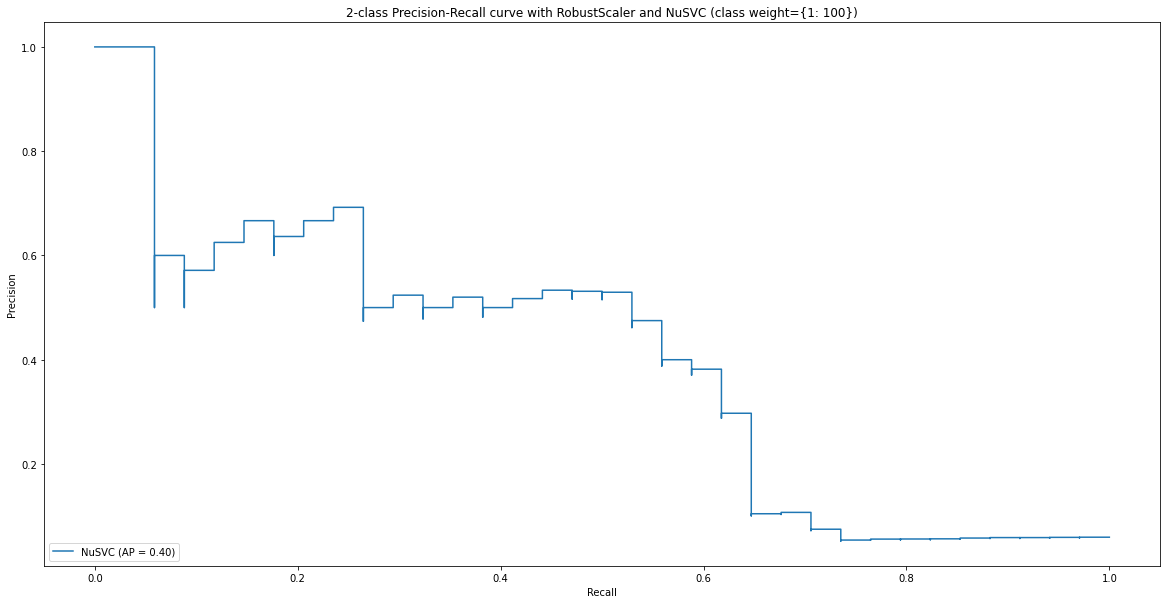

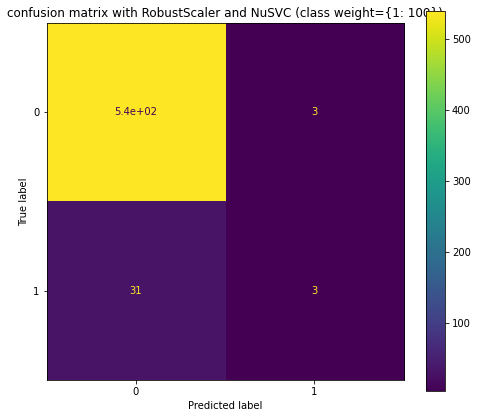

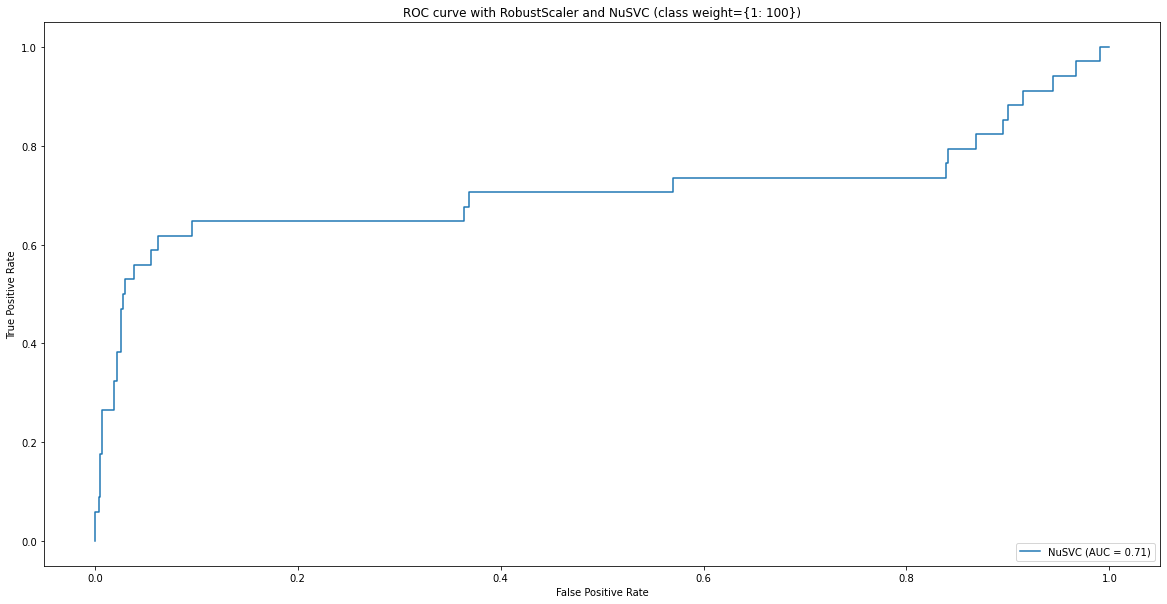

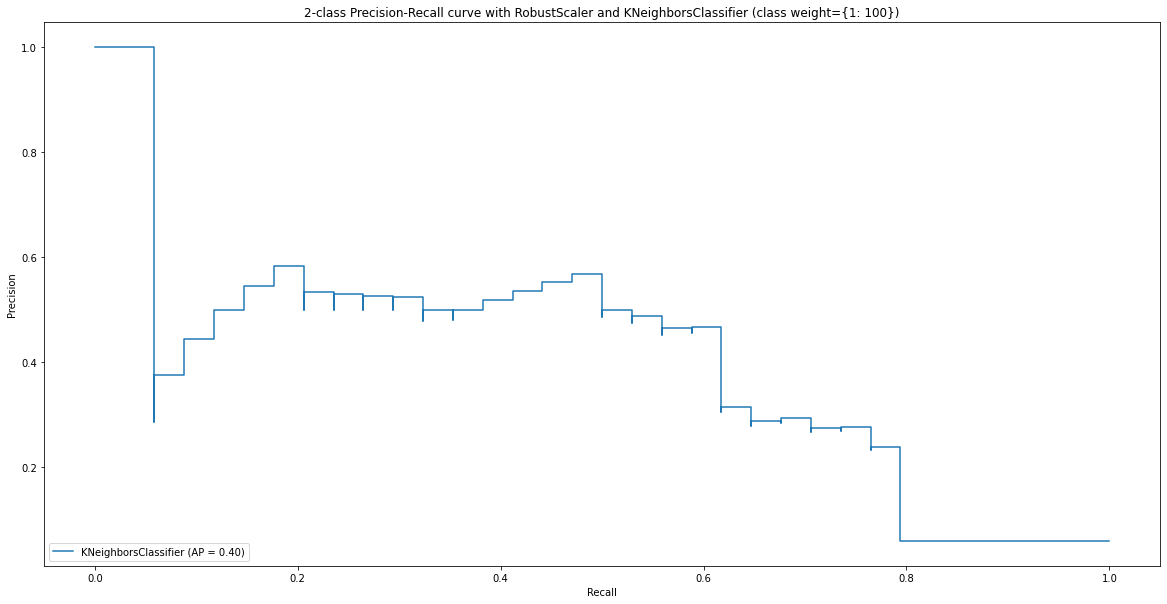

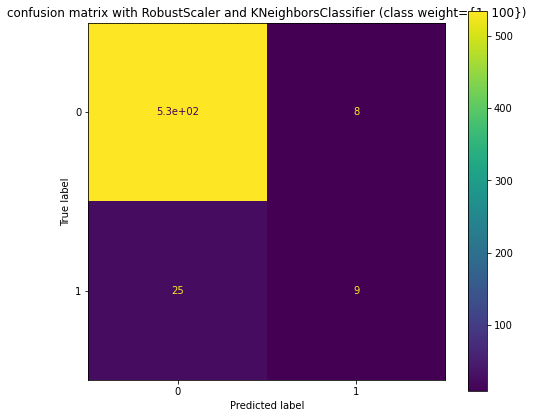

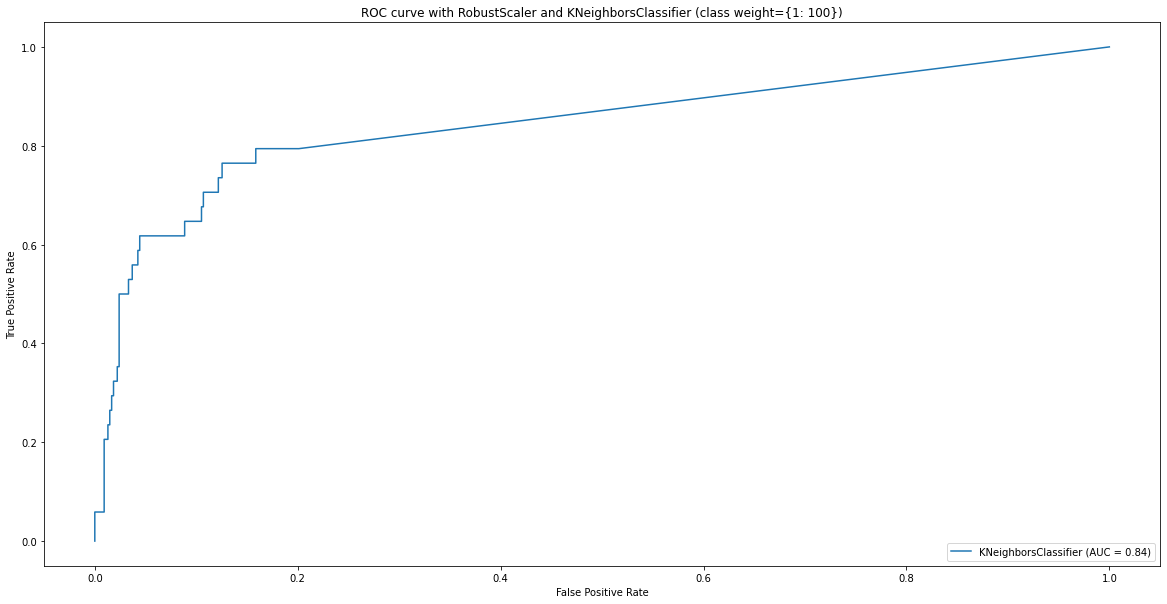

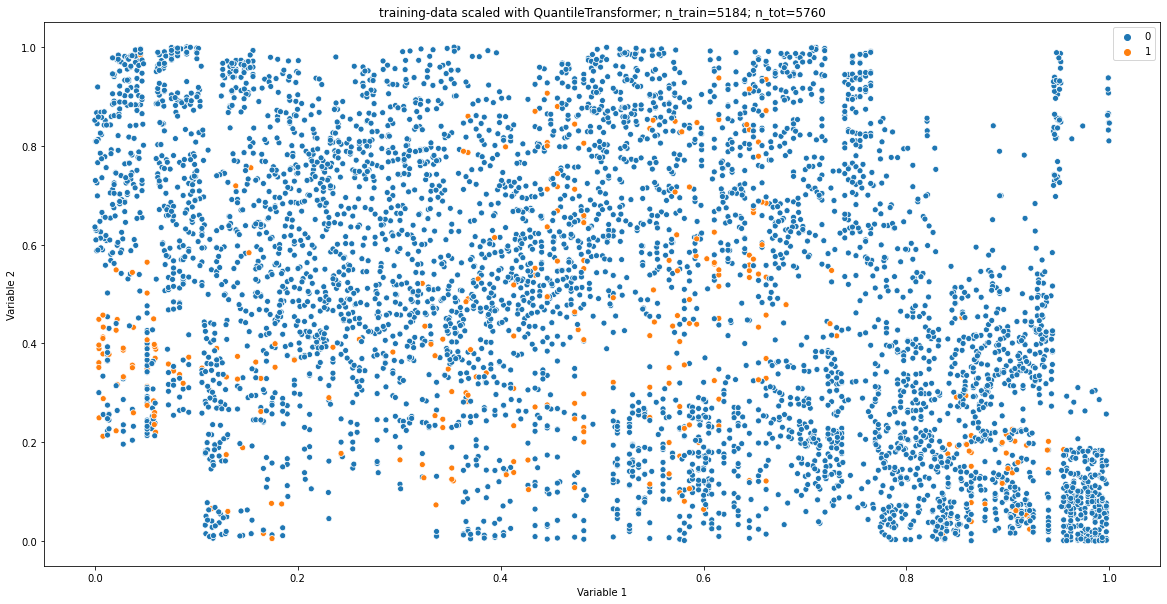

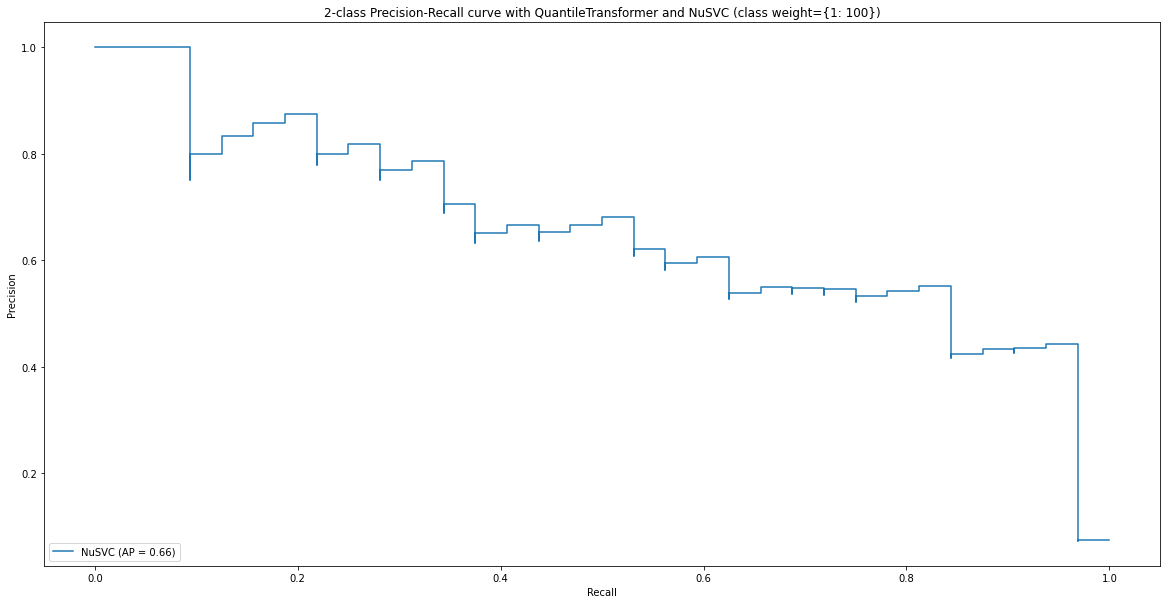

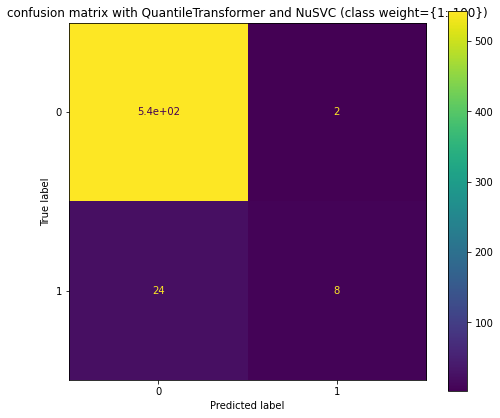

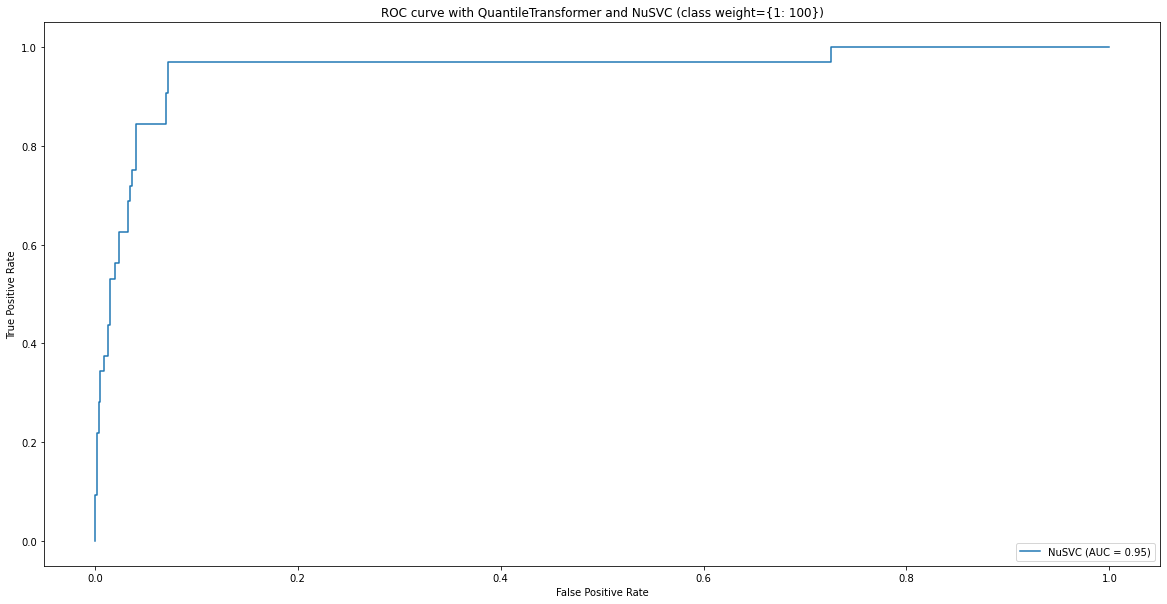

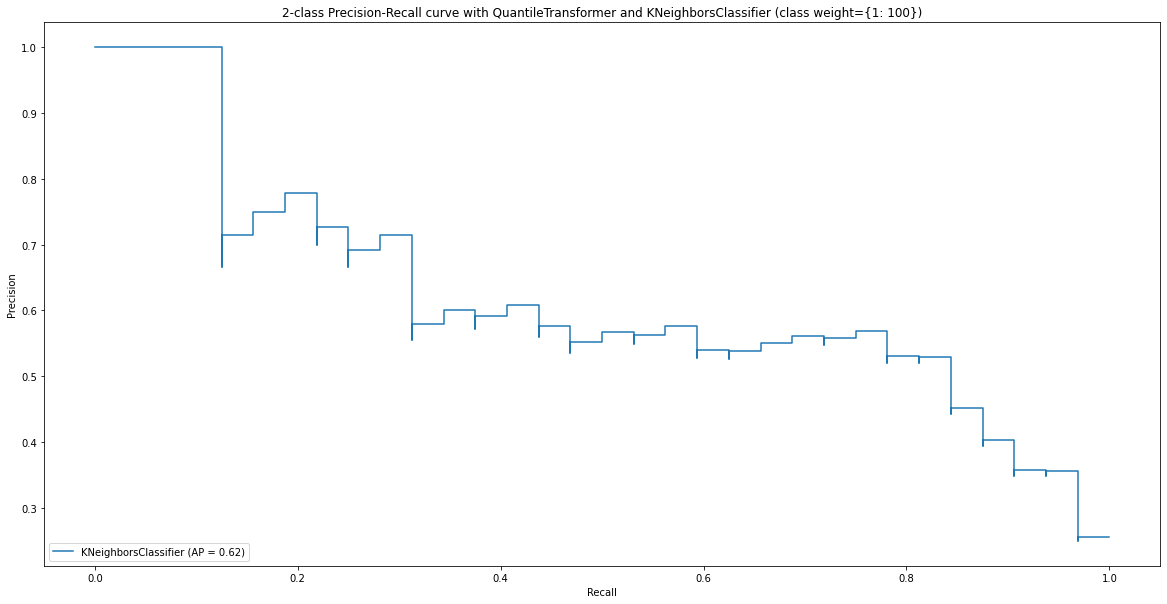

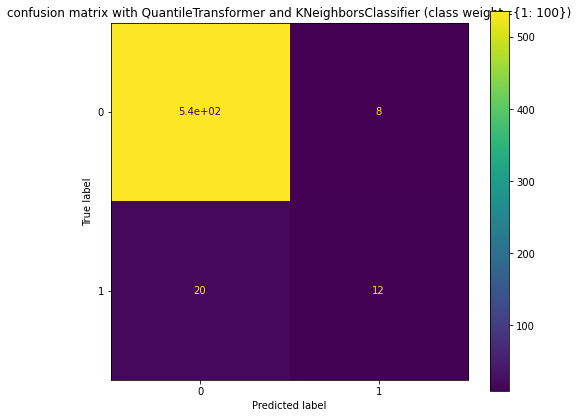

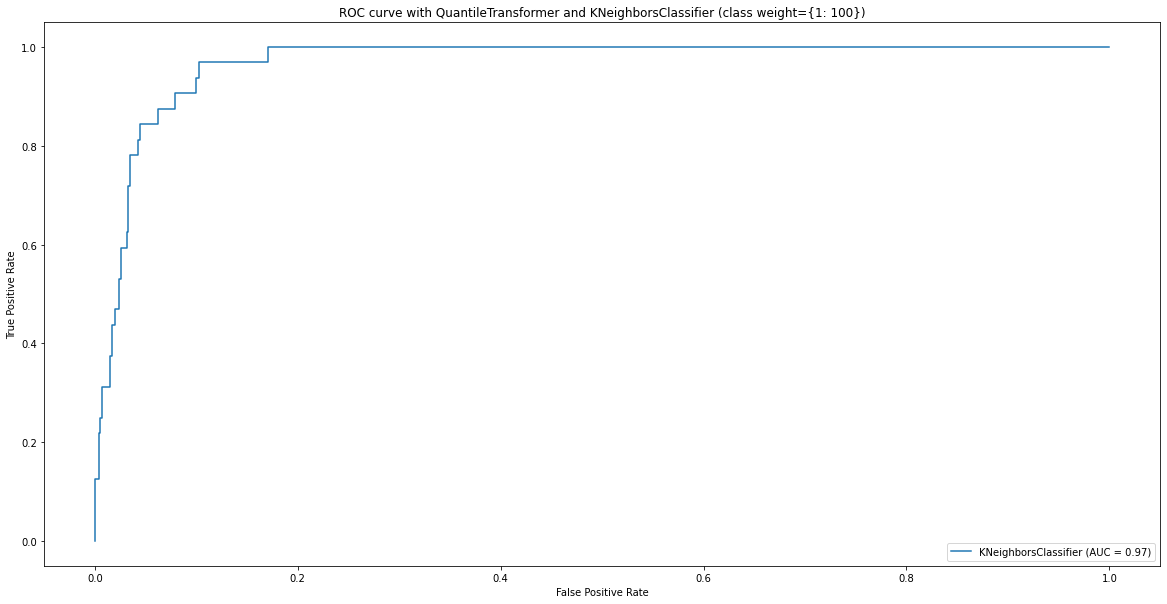

In [73]:
orig_stdout = sys.stdout
f = open(os.path.join(out_dir, 'out.txt'), 'w')
sys.stdout = f

for scaler in scalers:
    
    print('########################')
    print('')
    print(scaler)
    print('')
    
    ##- scaling
    X_s = scaler.fit_transform(X)

    ##- splitting in train and test samples
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X_s,
                                                                        Y,
                                                                        test_size=1-config.getfloat('machine_learning', 'train_fraction'))

    plt.figure(figsize=(20,10))
    sbs.scatterplot(x=X_train[:,0],
                    y=X_train[:,1],  
                    hue=y_train)

    plt.title('training-data scaled with {0}; n_train={1}; n_tot={2}'.format(str(scaler).rsplit('(')[0], len(X_train), len(X_s)))
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.savefig(os.path.join(out_dir, 'scatter_plot_scaled_traindata_{}.png'.format(str(scaler).rsplit('(')[0])), dpi=300)
    
    for clf in clfs:
        
        print('====================================')
        print('')
        print(clf)
        print('')
        
        ##- k-fold cross-validation
        accuracy = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
        print('the average k-fold cross-validation scores with k=10 for scaler {} and for this clf are {}'.format(scaler, accuracy.mean()))
        print('')
        
        ##- Fit the model with the scaled training data and the boolean conflict data
        clf.fit(X_train, y_train)
        
        ##- Predict with the scaled prediction data
        y_pred = clf.predict(X_test)
        
        ##- Evaluation
        try:
            y_score = clf.decision_function(X_test)
        except:
            y_score = np.nan
        
        print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
        print("Precision:", metrics.precision_score(y_test, y_pred))
        print("Recall:", metrics.recall_score(y_test, y_pred))
        print('')
        
        print(metrics.classification_report(y_test, y_pred))
        print('')
        
        try:
            average_precision = metrics.average_precision_score(y_test, y_score)
            print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        except:
            print('Average precision-recall score could not be computed')
            pass  
    
        print('Brier score: to be implemented!')
    
        try:
            print('ROC score: {0:0.2f}'.format(metrics.roc_auc_score(y_test, y_score)))
        except:
            print('ROC score could not be computed')
            pass
    
        print('F1 score: {0:0.2f}'.format(metrics.f1_score(y_test, y_pred)))
        print('')
        
        fig, ax = plt.subplots(1, 1, figsize=(20,10))
        disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
        disp.ax_.set_title('2-class Precision-Recall curve with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
        plt.savefig(os.path.join(out_dir, 'precision_recall_curve_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)

        fig, ax = plt.subplots(1, 1, figsize=(8, 7))
        ax.set_title('confusion matrix with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
        metrics.plot_confusion_matrix(clf, X_test, y_test, ax=ax)
        plt.savefig(os.path.join(out_dir, 'confusion_matrix_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)
        plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(20,10))
        ax.set_title('ROC curve with {} and {} (class weight={})'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0], class_weight))
        metrics.plot_roc_curve(clf, X_test, y_test, ax=ax)
        plt.savefig(os.path.join(out_dir, 'ROC_curve_{}+{}.png'.format(str(scaler).rsplit('(')[0], str(clf).rsplit('(')[0])), dpi=300)

sys.stdout = orig_stdout
f.close()

All output, also print statements, are stored in the output folder!